In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import joblib
import seaborn as sns
import anndata
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.1
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)

## Pairwise DMR

In [3]:
pairwise_dmr = anndata.read_h5ad(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/ExcDMR/PairwiseDMR.h5ad'
)
dmr_counts = pairwise_dmr.X.sum(axis=1)
dmr_counts = pd.Series(dmr_counts.A1, index=pairwise_dmr.obs.set_index(['cluster_a', 'cluster_b']).index)

In [4]:
dmr_counts.index = dmr_counts.index.map(lambda i: tuple(sorted(i)))
final_dmr_counts = dmr_counts.groupby(dmr_counts.index).sum()

dmr_count = pd.DataFrame([
    final_dmr_counts.index.map(lambda i: i[0]),
    final_dmr_counts.index.map(lambda i: i[1]), final_dmr_counts.values
],
                                index=['a', 'b', 'count'
                                       ]).T.set_index(['a', 'b'
                                                       ])['count']
dmr_count_r = pd.Series(dmr_count.values, index=dmr_count.index.map(lambda i: i[::-1]))
dmr_count_table = pd.concat([dmr_count, dmr_count_r]).unstack().fillna(0).astype(int)

In [5]:
# order by dendrogram
cluster_order = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/AssignGeneToTree/RTree/Exc.dendrogram.lib'
)['ivl']

name_map = {
    i.replace('_', '.').replace('-', '.'): i
    for i in dmr_count_table.index
}
cluster_order = [name_map[i] for i in cluster_order]

dmr_count_table = dmr_count_table.reindex(index=cluster_order, columns=cluster_order)

In [6]:
mask = np.zeros_like(dmr_count_table)
mask[np.triu_indices_from(mask)] = True

In [7]:
counts = dmr_count_table.unstack()
counts = counts[counts > 0]
min_dmr, max_dmr = counts.min(), counts.max()

## Cluster Gene mCH Level

In [8]:
with pd.HDFStore('/home/hanliu/project/mouse_rostral_brain/DMR/SubType/Total/DMRInfo.h5') as hdf:
    dmr_rate = hdf['Rate']

In [9]:
example_pair = ['CA1_Chrm3', 'CA3_Cadm2']


In [10]:
pair_id = pairwise_dmr.obs_names[
    pairwise_dmr.obs['cluster_a'].isin(example_pair)
    & pairwise_dmr.obs['cluster_b'].isin(example_pair)][0]
pair_id

'685'

In [11]:
related_dmr = pairwise_dmr.var_names[pairwise_dmr.var_vector(pair_id).astype(bool)]

use_rate = dmr_rate.loc[related_dmr, example_pair].copy()
dmr_delta = (use_rate.iloc[:, 0] - use_rate.iloc[:, 1]).sort_values(ascending=False)
use_rate_up = use_rate.loc[dmr_delta[dmr_delta > 0.4].index]
use_rate_low = use_rate.loc[dmr_delta[dmr_delta < -0.4].index]

In [12]:
use_rate_up.shape

(68991, 2)

In [13]:
use_rate_low.shape

(100000, 2)

## Plot

(15, 11)


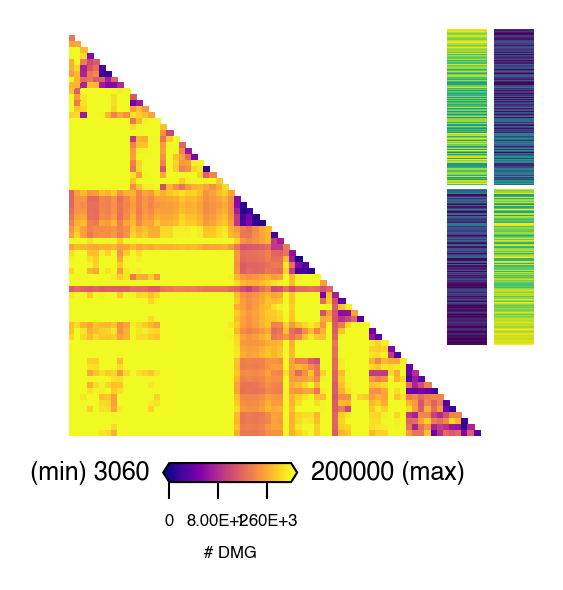

In [14]:
fig = plt.figure(figsize=(2, 2), dpi=300)

gs = fig.add_gridspec(20, 10)

ax_heatmap = fig.add_subplot(gs[:18, :9])
ax_cbar = fig.add_subplot(gs[-1, 2:5])
ax_up_left = fig.add_subplot(gs[0:7, 8])
ax_up_right = fig.add_subplot(gs[0:7, 9])
ax_low_left = fig.add_subplot(gs[7:14, 8])
ax_low_right = fig.add_subplot(gs[7:14, 9])

ax = ax_heatmap
sns.heatmap(dmr_count_table.fillna(0),
            ax=ax,
            vmin=0,
            vmax=200000,
            cmap='plasma',
            mask=mask,
            cbar=None)
ax.set(xticks=[], yticks=[], xlabel='', ylabel='')

ax = ax_cbar
from ALLCools.plot.color import plot_colorbar
plot_colorbar(ax,
              cmap='plasma',
              hue_norm=(0, 2000),
              cnorm=None,
              label='# DMG',
              orientation='horizontal',
              labelsize=4,
              linewidth=0.5)
ax.text(-0.05,
        0.5,
        f'(min) {min_dmr} ',
        fontsize=labelsize,
        ha='right',
        va='center',
        transform=ax.transAxes,
        clip_on=False)
ax.text(1.05,
        0.5,
        f' {max_dmr} (max)',
        fontsize=labelsize,
        ha='left',
        va='center',
        transform=ax.transAxes,
        clip_on=False)
example_loc = dmr_count_table.index.get_loc(example_pair[1]), dmr_count_table.columns.get_loc(example_pair[0])
print(example_loc)

ax = ax_up_left
ax.imshow(use_rate_up.iloc[:, 0].values[:, None],
          aspect='auto',
          vmin=0,
          vmax=1)
ax.axis('off')
ax = ax_up_right
ax.imshow(use_rate_up.iloc[:, 1].values[:, None],
          aspect='auto',
          vmin=0,
          vmax=1)
ax.axis('off')
ax = ax_low_left
ax.imshow(use_rate_low.iloc[:, 0].values[:, None],
          aspect='auto',
          vmin=0,
          vmax=1)
ax.axis('off')
ax = ax_low_right
ax.imshow(use_rate_low.iloc[:, 1].values[:, None],
          aspect='auto',
          vmin=0,
          vmax=1)
ax.axis('off')

fig.savefig('PairwiseDMR.pdf')

In [15]:
(dmr_delta > 0).sum()

68991

In [16]:
(dmr_delta < 0).sum()

100000